In [20]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt

import iris
import iris.plot as iplt
import iris.quickplot as qplt
import cftime
import datetime

from iris.experimental.equalise_cubes import equalise_attributes

from shapely.geometry import MultiPoint # used for clipping geographic regions

import numpy as np
import pandas as pd
from random import randint

import shape_utils as shape
import atmos_nrt_utils

import os
import requests  # Used to download data
import csv

In [21]:
# Go to repository root directory
if "_changed_dir" not in locals():
    os.chdir("../")
    _changed_dir = True

# Overview
This file generates the .csv files describing the average air quality metric for every Principal Urban Area (PUA) in the UK from 01/01/2020 until 17/06/2020. We provide a description of this process in the notebook "atmos_nrt_example.ipynb" for a single PUA and air quality metric. This notebook simply loops through all PUA and the 4 air quality metrics and outputs 1 x csv file for each metric. The air quality metrics are:
* Nitrogen Dioxide
* Ozone
* Sulpur Dioxide
* Particulate Matter (< 2.5 micron diameter)
* Particulate Matter (< 10 micron diameter)


## Parameters

In [61]:
#Air quality data and time settings
url_prefix   = "https://metdatasa.blob.core.windows.net/covid19-response"
metric       = "pm10"
start_date   = datetime.datetime(2020, 1, 1)
end_date     = datetime.datetime(2020, 6, 19) 
raw_data_dir = os.path.join("data", "raw", "metoffice")

#Location of the region shape files
region_shape_file = "2015_PUA_polygons_UK.shx"
region_shape_dir  = os.path.join("data", "annex", "metoffice")

#Controlling csv output
output_dir = os.path.join("data", "processed")
output_fmt = "%.4f"

## Workflow
* Load data
* Split by region
* Calculate average
* Combine into single cube along time vector
* Convert to pandas.DataFrame
* Export to .csv

In [62]:
#Construct the urls to download the raw data from the MET Office website
date_arr = np.arange(start_date, end_date, datetime.timedelta(days=1)).astype(datetime.datetime)
date_str = [date.strftime("%Y%m%d") for date in date_arr]

urls = [atmos_nrt_utils.metoffice_url_generator(metric, d_str) for d_str in date_str]

raw_data_dir = os.path.join('data', 'raw', 'metoffice')
if not os.path.exists(raw_data_dir):
    os.makedirs(raw_data_dir)

In [63]:
urls

['metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200101.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200102.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200103.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200104.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200105.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200106.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200107.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200108.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200109.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200110.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200111.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200112.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200113.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200114.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200115.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly_pm10_20200116.nc',
 'metoffice_aqum_hourly/pm10/aqum_hourly

In [67]:
file_paths = atmos_nrt_utils.get_data_file_paths(urls, url_prefix, raw_data_dir)

In [68]:
#Load in the data from multiple files as a iris.Cube.CubeList
cube_list  = iris.load(file_paths)
cube_slice = cube_list[0]

#Extract the coordinate reference system from one of the cubes. We will use this later.
crs = cube_slice[0].coord_system()

In [69]:
cube_list

[<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projection_x_coordinate: 548)>,
<iris 'Cube' of mass_concentration_of_pm10_ambient_aerosol_in_air / (ug/m3) (time: 24; projection_y_coordinate: 704; projecti

In [70]:
#We must equalise the metadata and remove the scalar coordinate 'forecast_reference_time' to allow cubes to concatenated
equalise_attributes(cube_list)
for cube in cube_list:
        cube.remove_coord('forecast_reference_time')
cube_stack = iris.cube.CubeList(cube_list).concatenate_cube()

Slough


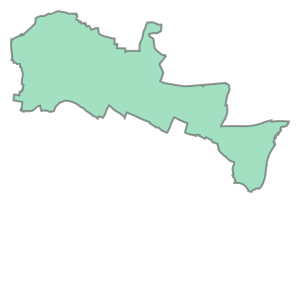

In [71]:
#Import the region information for clipping the UK-wide dataset
regions_reader = shpreader.Reader(os.path.join(region_shape_dir, region_shape_file))
region_ids = [record.attributes['PUAName'] for record in regions_reader.records()]

#Get a random geometry to check it's all working as expected
region_name   = atmos_nrt_utils.rand_id(region_ids)
region_record = atmos_nrt_utils.get_region_record(region_name, regions_reader)
print(region_name)
region_record.geometry

In [72]:
df_list = []
for single_region_name in region_ids:
    
    print(single_region_name)
    
    #Get the region
    region_record = atmos_nrt_utils.get_region_record(single_region_name, regions_reader)
    
    #Clip the data to this region
    cut_cubes = atmos_nrt_utils.cut_cubes_to_shape(cube_stack, region_record)
    
    #Calculate the average over this region
    #mean_cubes = cube.collapsed(['projection_y_coordinate','projection_x_coordinate'],iris.analysis.MEAN) for cube in cut_cubes]
    mean_cubes = cut_cubes[0].collapsed(['projection_y_coordinate','projection_x_coordinate'],iris.analysis.MEAN)
    
    #Remove the scalar coordinate 'forecast_reference_time' to allow cubes to concatenated
    #for cube in mean_cubes:
    #    cube.remove_coord('forecast_reference_time')
    #concat_mean_cubes = iris.cube.CubeList(mean_cubes).concatenate_cube()
    
    #df = atmos_nrt_utils.convert_cube_to_dateframe(concat_mean_cubes, single_region_name)
    df = atmos_nrt_utils.convert_cube_to_dateframe(mean_cubes, single_region_name)
    
    df_list.append(df)

Aberdeen
Blackburn
Bradford
Bournemouth
Birmingham
Brighton
Bristol
Burnley
Barnsley
Cambridge
Cardiff
Coventry
Crawley
Dundee
Derby
Doncaster
Edinburgh
Exeter
Aldershot
Blackpool
Glasgow
Gloucester
Huddersfield
Hull
Ipswich
Leicester
London
Leeds
Luton
Liverpool
Manchester
Chatham
Mansfield
Milton Keynes
Newcastle
Nottingham
Northampton
Newport
Norwich
Oxford
Peterborough
Plymouth
Portsmouth
Preston
Reading
Swansea
Sheffield
Slough
Swindon
Southampton
Sunderland
Southend
Stoke
Basildon
Telford
Middlesbrough
Warrington
Wakefield
Birkenhead
Wigan
Worthing
York
Belfast


In [73]:
df_combined = pd.concat(df_list, axis=1)
df_combined.head(10)

,Aberdeen,Blackburn,Bradford,Bournemouth,Birmingham,Brighton,Bristol,Burnley,Barnsley,Cambridge,...,Basildon,Telford,Middlesbrough,Warrington,Wakefield,Birkenhead,Wigan,Worthing,York,Belfast
01/01/2020 01:00:00,22.449367,25.878183,16.300001,21.046512,33.209729,34.575928,41.735178,26.293814,16.172414,34.770001,...,41.244186,30.390098,11.919048,24.139132,16.647321,25.195557,25.702816,34.970585,13.272528,35.165673
01/01/2020 02:00:00,23.341772,25.029093,18.712600,20.515117,38.482103,36.501854,33.252177,27.114434,20.623276,37.605002,...,39.502328,30.490099,11.886905,24.402899,23.141963,26.153334,24.729578,35.835295,17.250550,28.902985
01/01/2020 03:00:00,25.296204,21.796365,21.978741,18.001744,41.451362,34.688888,25.396048,26.335052,21.823276,40.200000,...,37.148841,35.151483,12.113095,26.810145,25.453572,29.054443,25.129578,31.494115,22.154946,29.863680
01/01/2020 04:00:00,28.139241,21.183638,22.842518,18.183721,41.415567,28.927777,22.012649,23.050514,24.020691,39.105002,...,35.216280,39.008910,14.404762,29.182607,25.843750,31.478890,27.033801,24.600001,26.058242,32.028857
01/01/2020 05:00:00,26.835443,23.690909,21.755119,18.163955,40.225293,22.624073,21.876681,20.614434,28.059482,38.035001,...,32.360465,39.219804,14.291667,32.957976,27.160714,33.705556,29.985915,18.294118,30.473627,29.428857
01/01/2020 06:00:00,22.622784,26.172727,21.706301,15.229651,31.891442,19.851852,20.244268,21.484536,33.893104,37.580002,...,31.630235,35.390098,13.742262,37.142030,31.347321,34.905556,33.918313,16.458825,30.073623,27.504975
01/01/2020 07:00:00,17.802533,30.292727,23.011023,15.526745,25.959923,19.198147,20.507511,24.349486,37.366379,30.720001,...,27.253489,32.405941,11.462500,38.791306,36.277679,35.771110,37.202816,16.647059,29.785714,26.394529
01/01/2020 08:00:00,12.381012,34.134546,26.831497,17.454070,23.248636,17.672223,21.820158,28.255673,35.670688,22.315001,...,27.681396,27.880197,10.499404,38.615938,40.417860,35.567779,38.774648,16.205882,31.694508,27.246269
01/01/2020 09:00:00,10.592406,33.469092,30.572442,16.310465,23.361478,19.701855,23.103161,31.936083,30.952588,21.100000,...,27.920930,24.389109,9.683334,40.723191,40.026786,35.187777,42.323944,19.164705,35.827473,25.850746
01/01/2020 10:00:00,11.944303,37.383638,34.007874,18.030234,22.112840,19.761111,25.487351,33.125775,29.874137,21.655000,...,26.981394,20.899999,10.529762,39.291309,37.566964,33.143335,42.681689,19.111766,36.446155,25.157214


In [74]:
#Setup csv header and meta - this file will be written to by successive DataFrames using the 'append' option
csv_name = metric + "_by_pua.csv"
csv_path = os.path.join(output_dir, csv_name)
with open(csv_path, 'w',  newline='') as csvfile:
    emission_writer = csv.writer(csvfile, delimiter=",")
    emission_writer.writerow(['quantity', 'mean_' + cube_list[0].name()])
    emission_writer.writerow(['units'   , cube_list[0].units])
    emission_writer.writerow(list(df_combined.columns))

In [75]:
df_combined.to_csv(csv_path, mode='a', header=False, index_label='date', float_format=output_fmt)

In [76]:
#Check we can read it in again
df_check = pd.read_csv(csv_path, skiprows = 2)
df_check.head(10)

,Aberdeen,Blackburn,Bradford,Bournemouth,Birmingham,Brighton,Bristol,Burnley,Barnsley,Cambridge,...,Basildon,Telford,Middlesbrough,Warrington,Wakefield,Birkenhead,Wigan,Worthing,York,Belfast
01/01/2020 01:00:00,22.4494,25.8782,16.3000,21.0465,33.2097,34.5759,41.7352,26.2938,16.1724,34.770,...,41.2442,30.3901,11.9190,24.1391,16.6473,25.1956,25.7028,34.9706,13.2725,35.1657
01/01/2020 02:00:00,23.3418,25.0291,18.7126,20.5151,38.4821,36.5019,33.2522,27.1144,20.6233,37.605,...,39.5023,30.4901,11.8869,24.4029,23.1420,26.1533,24.7296,35.8353,17.2505,28.9030
01/01/2020 03:00:00,25.2962,21.7964,21.9787,18.0017,41.4514,34.6889,25.3960,26.3351,21.8233,40.200,...,37.1488,35.1515,12.1131,26.8101,25.4536,29.0544,25.1296,31.4941,22.1549,29.8637
01/01/2020 04:00:00,28.1392,21.1836,22.8425,18.1837,41.4156,28.9278,22.0126,23.0505,24.0207,39.105,...,35.2163,39.0089,14.4048,29.1826,25.8438,31.4789,27.0338,24.6000,26.0582,32.0289
01/01/2020 05:00:00,26.8354,23.6909,21.7551,18.1640,40.2253,22.6241,21.8767,20.6144,28.0595,38.035,...,32.3605,39.2198,14.2917,32.9580,27.1607,33.7056,29.9859,18.2941,30.4736,29.4289
01/01/2020 06:00:00,22.6228,26.1727,21.7063,15.2297,31.8914,19.8519,20.2443,21.4845,33.8931,37.580,...,31.6302,35.3901,13.7423,37.1420,31.3473,34.9056,33.9183,16.4588,30.0736,27.5050
01/01/2020 07:00:00,17.8025,30.2927,23.0110,15.5267,25.9599,19.1981,20.5075,24.3495,37.3664,30.720,...,27.2535,32.4059,11.4625,38.7913,36.2777,35.7711,37.2028,16.6471,29.7857,26.3945
01/01/2020 08:00:00,12.3810,34.1345,26.8315,17.4541,23.2486,17.6722,21.8202,28.2557,35.6707,22.315,...,27.6814,27.8802,10.4994,38.6159,40.4179,35.5678,38.7746,16.2059,31.6945,27.2463
01/01/2020 09:00:00,10.5924,33.4691,30.5724,16.3105,23.3615,19.7019,23.1032,31.9361,30.9526,21.100,...,27.9209,24.3891,9.6833,40.7232,40.0268,35.1878,42.3239,19.1647,35.8275,25.8507
01/01/2020 10:00:00,11.9443,37.3836,34.0079,18.0302,22.1128,19.7611,25.4874,33.1258,29.8741,21.655,...,26.9814,20.9000,10.5298,39.2913,37.5670,33.1433,42.6817,19.1118,36.4462,25.1572


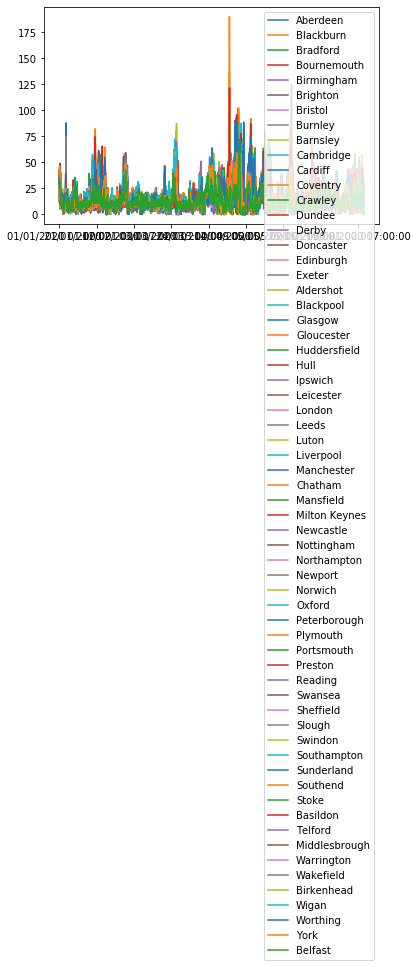

In [77]:
df_check.plot()